# Занятия 7.2. Сложные методы прогнозирования

Артем Языков, ВШЭ, ВЦ РАН
25.11.2017

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta

#pip install seaborn
# import seaborn as sns
import statsmodels.api as sm

import statsmodels.tsa.api as smt
# import scipy.stats as scs

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# если графики не рисуются
%matplotlib inline

In [4]:
# полезная функция для построения основных графиков
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        # mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (2, 0))
        qq_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')

        plt.tight_layout()
    return

## Подготовка к работе

In [5]:
# Загрузим данные
df = pd.read_csv('portland-oregon-average-monthly-.csv', index_col=0)
df.index.name=None
df.reset_index(inplace=True)
df.drop(df.index[114], inplace=True)

In [6]:
#  Укажем формат времени
start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,114)]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

In [7]:
df.columns= ['riders']
df['riders'] = df.riders.apply(lambda x: int(x)*100)

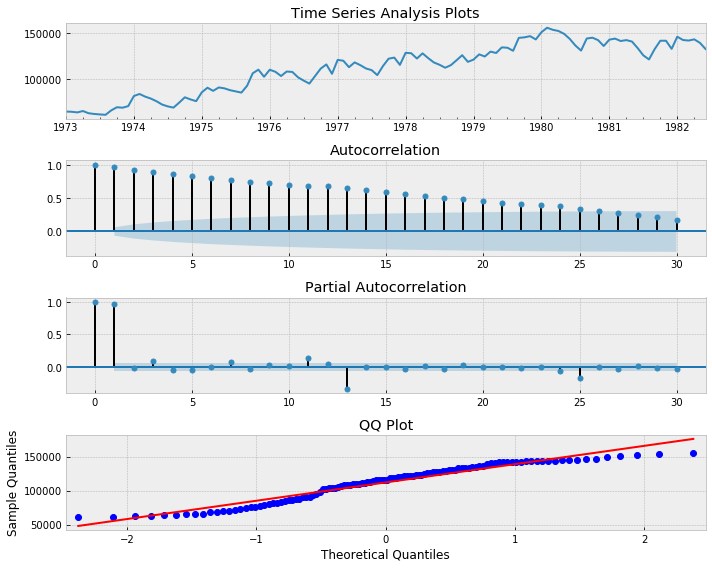

In [8]:
tsplot(df.riders, lags=30)

## Разделяем ряд на тренд, сезонность и шум

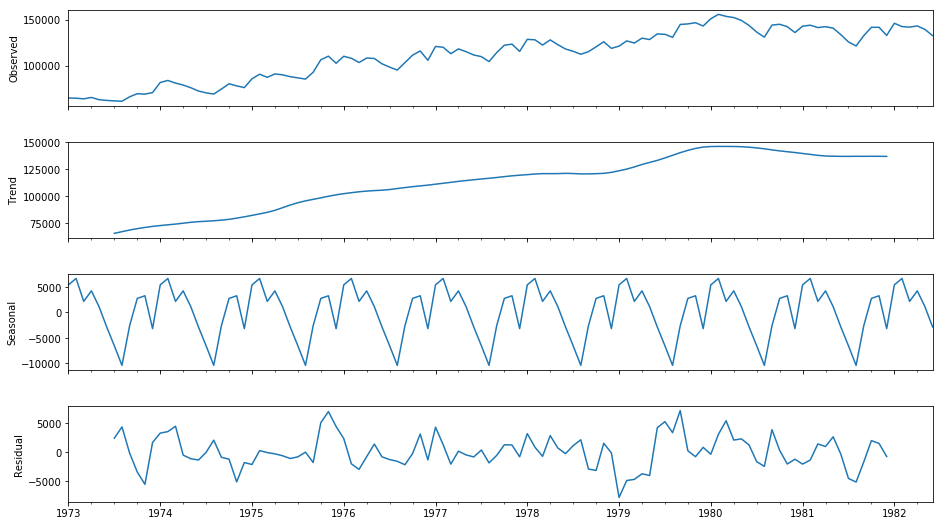

In [9]:
decomposition = seasonal_decompose(df.riders, freq=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

## Проверка стационарности

In [10]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test:
    print
    'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


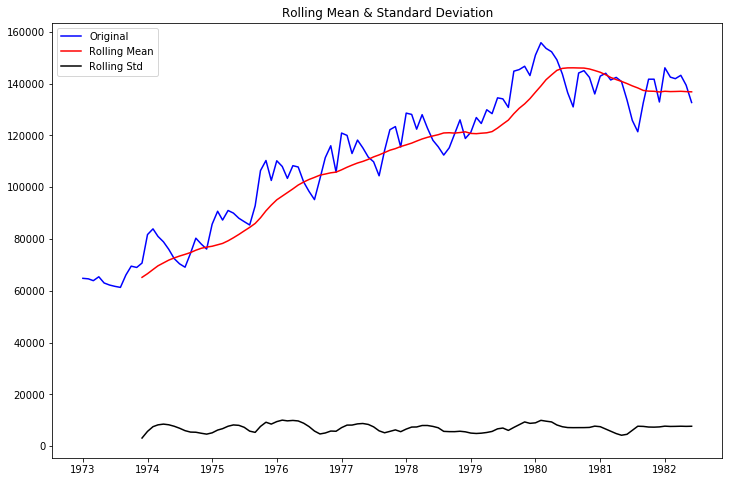

Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [11]:
test_stationarity(df.riders)

Ряд стацоинарный, если ели его среднее (rolling mean) и отклонение (rolling deviation) не меняются с течением времени. На графике видно, что это не так.

Более строго: ряд стационарен на уровне значимости 95%, если p value меньше, чем 0,05. Здесь p value = 0,51.

### Логарифмирование и стационарность

Ряд не стационарный - скользящее среднее сильно изменяется, скользящее отклонение тоже имеет занчимые колебания. Попробуем добиться стационарности с помощью логарифмирования.

In [12]:
df.riders_log = df.riders.apply(lambda x: np.log(x))


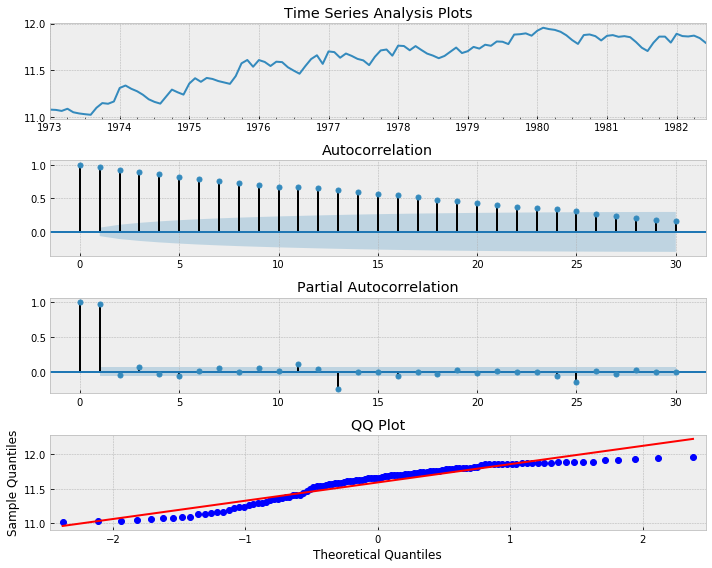

In [13]:
tsplot(df.riders_log, lags=30)

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


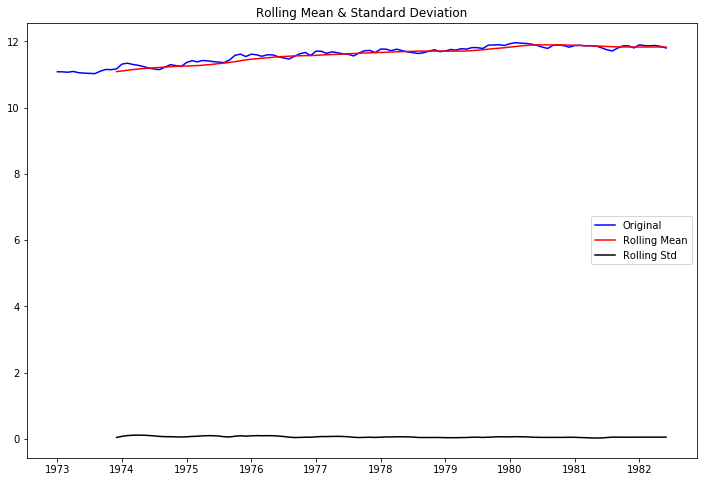

Test Statistic                  -1.677830
p-value                          0.442570
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [14]:
test_stationarity(df.riders_log)

Результат логарифмирования:
 - p value слегка меньшилось (0,51 -> 0,44), но до стационарности еще далеко
 - скользящее среднее стало намного стабильнее, но все равно изменяется с течением времени
 - отклонение на вид стало стабильным

### Первая разность и стационарность

Вычислим первую разность ряда (y_t - y_{t-1}) и оценим ее стационарность. 

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


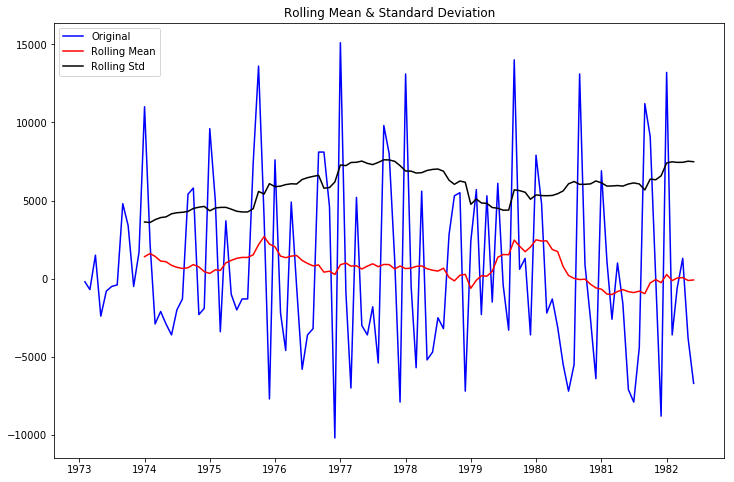

Test Statistic                  -1.938696
p-value                          0.314082
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [15]:
df['first_difference'] = df.riders - df.riders.shift(1)
test_stationarity(df.first_difference.dropna(inplace=False))

p value = 0,31 - пока не добились стационарности. Попробуем логарифмировать.

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


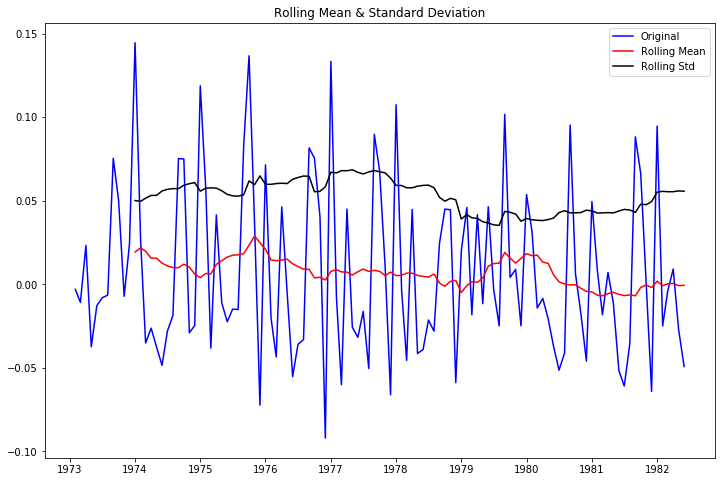

Test Statistic                  -2.047539
p-value                          0.266126
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [16]:
df['log_first_difference'] = df.riders_log - df.riders_log.shift(1)
test_stationarity(df.log_first_difference.dropna(inplace=False))

### Сезонная разность и стационарность

Стало немного лучше (p value = 0,26, было 0,31), но все равно ряд не стационарный.
Попробуем взять сезонную разность - 12 месяцев.

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


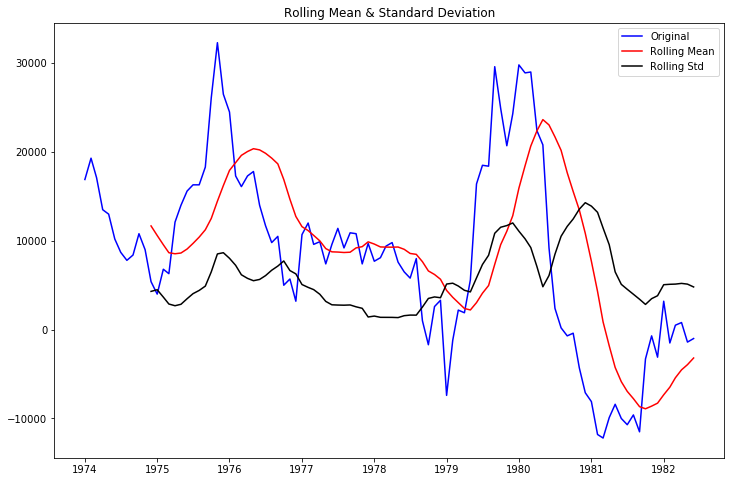

Test Statistic                 -2.469741
p-value                         0.123011
#Lags Used                      3.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


In [17]:
df['seasonal_difference'] = df.riders - df.riders.shift(12)
test_stationarity(df.seasonal_difference.dropna(inplace=False))

Еще лучше - p value 0,12 вместо 0,21. Но опять не то, что нужно.
Логарифмируем сезонную разность.

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


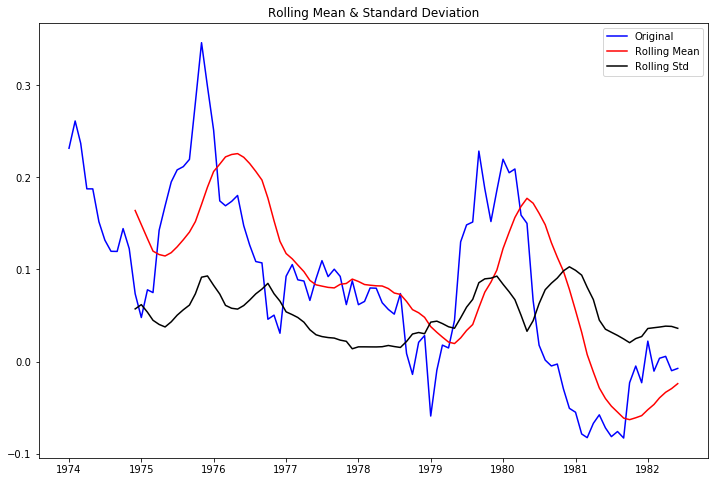

Test Statistic                  -1.919681
p-value                          0.322860
#Lags Used                       0.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [18]:
df['log_seasonal_difference'] = df.riders_log - df.riders_log.shift(12)
test_stationarity(df.log_seasonal_difference.dropna(inplace=False))

Получилось даже хуже, чем было - p value выросло с 0,12 до 0,32.

### Комбинация первой и сезонной разностей
Попробуем взять первую разность сезонных разностей. Т.е. вот такой ряд: (y_t - y_{t-12}) - (y_{t-12} - y_{t-24}).

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


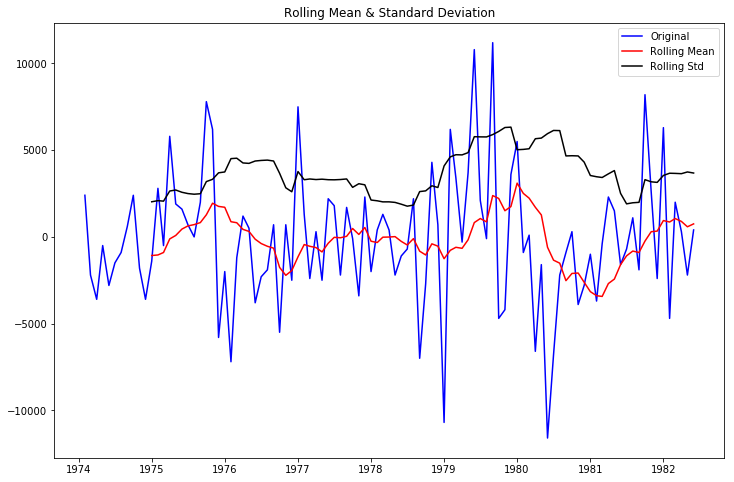

Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [20]:
df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))

Вот этот ряд уже стационарен - P value = 10^(-15). Попробуем еще взять логарифм от него, чтобы сгладить колебания в районе 1975-1977 и 1979-1982.

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


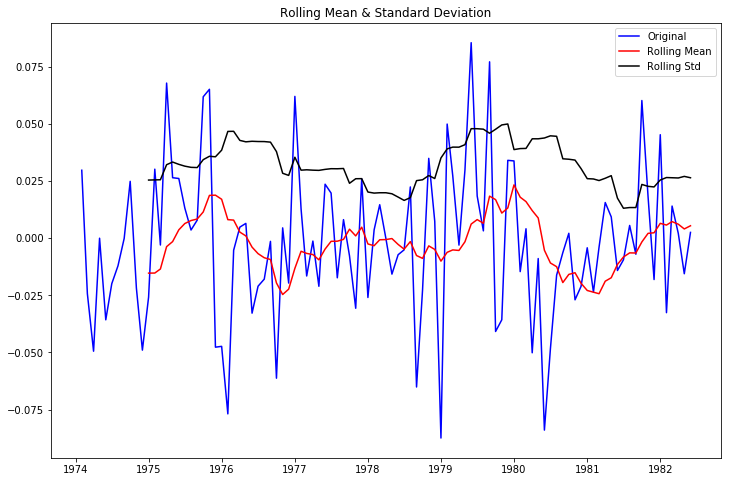

Test Statistic                -8.882112e+00
p-value                        1.309452e-14
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [21]:
df['log_seasonal_first_difference'] = df.log_first_difference - df.log_first_difference.shift(12)
test_stationarity(df.log_seasonal_first_difference.dropna(inplace=False))

Логарифм снова не помог - p value вырос до 10^(-14).
Вернемся к первой разности сезонных разностей и построим ее графики.

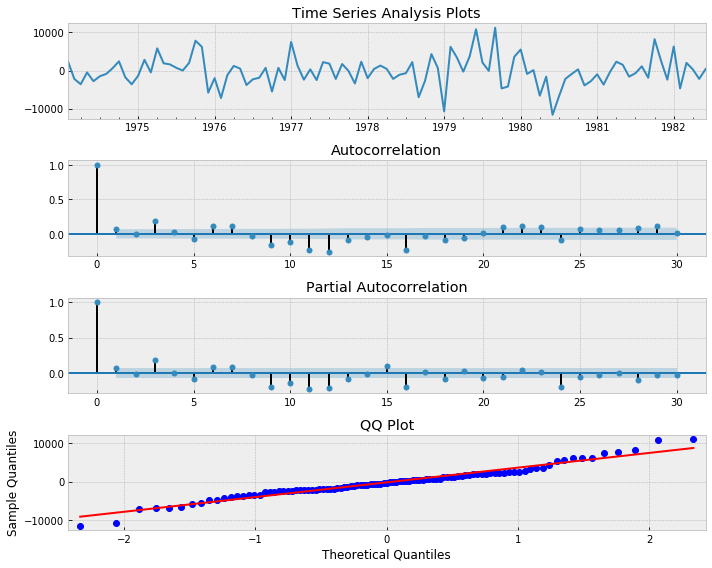

In [22]:
tsplot(df.seasonal_first_difference.iloc[13:], lags=30)

## Дополнительная информация о трансформации данных
http://people.duke.edu/~rnau/whatuse.htm

# Подбор модели
Попробуем сначала построить модель MA(1) с учетом длины сезона 12 периодов (месяцев).

In [23]:
mod = sm.tsa.statespace.SARIMAX(df.riders, trend='n', order=(0,1,0), seasonal_order=(0,1,1,12))
results = mod.fit()
print(results.summary())


                                 Statespace Model Results                                 
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -976.135
Date:                            Sat, 25 Nov 2017   AIC                           1956.271
Time:                                    14:57:48   BIC                           1961.743
Sample:                                01-01-1973   HQIC                          1958.492
                                     - 06-01-1982                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.1377      0.050     -2.757      0.006      -0.236      -0.040
sigma2      1.424e+07   2.62e-10   

Сравним ее с моделью ARMA(1,1) - AR(1) и MA(1).

In [24]:
mod = sm.tsa.statespace.SARIMAX(df.riders, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -970.257
Date:                            Sat, 25 Nov 2017   AIC                           1946.514
Time:                                    14:58:35   BIC                           1954.723
Sample:                                01-01-1973   HQIC                          1949.845
                                     - 06-01-1982                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5590      0.084      6.679      0.000       0.395       0.723
ma.S.L12      -0.9982      0.117   

Вторая модель немного лучше по log likelihood (он чуть больше) и AIC (критерий Акаике, он чуть ниже).

# Построение прогноза
Используем вторую (лучшую) модель, чтобы спрогнозировать последние значения ряда

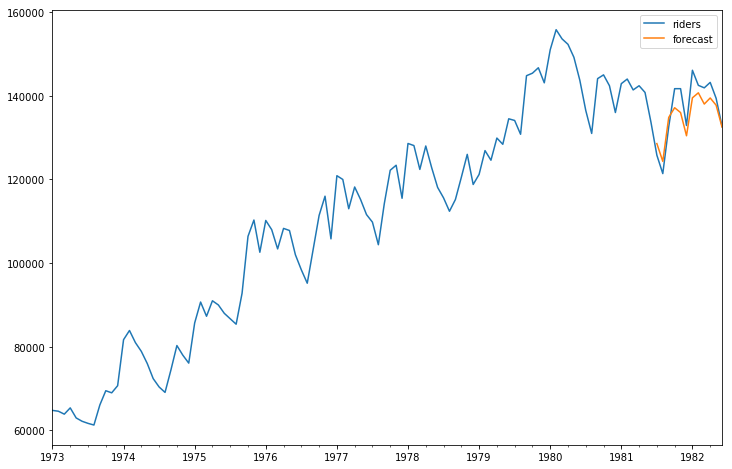

In [26]:
df['forecast'] = results.predict(start = 102, end= 114, dynamic= True)
df[['riders', 'forecast']].plot(figsize=(12, 8))
# plt.savefig('ts_df_predict.png', bbox_inches='tight')

## Сравнение прогноза с данными

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """


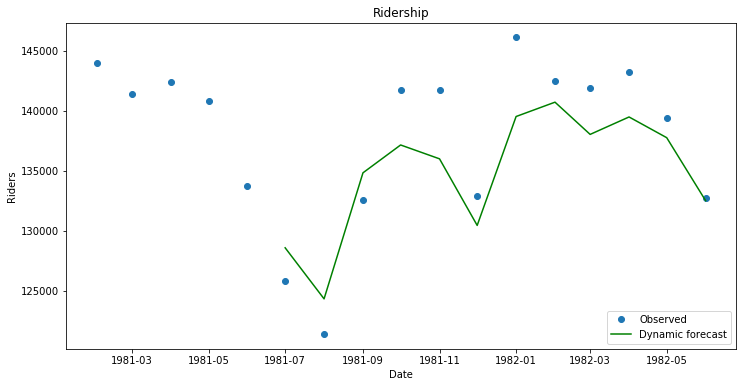

In [27]:
npredict =df.riders['1982'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='Ridership', xlabel='Date', ylabel='Riders')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'riders'], 'o', label='Observed')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'forecast'], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')
# plt.savefig('ts_predict_compare.png', bbox_inches='tight')

Подготовим следующие даты (после июля 1982 г.) для построения прогноза

In [28]:
start = datetime.datetime.strptime("1982-07-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= df.columns)
df = pd.concat([df, future])